In [128]:
import os
import time
import numpy as np
import collections
import matplotlib.pyplot as plt

from tqdm import trange
from constants import *
from scipy.special import k0
from ULDM_Simulator import *


plt.style.use('./myplot.mplstyle')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Monte Carlo

In [174]:
class ULDM_Signal2:
    def __init__(self, mass, sigma, T, na):
        '''
        Initialize the instance

        Input
            mass    (scalar)        mass [Hz]
            sigma   (scalar)        vel. dispersion [km/sec]
            T       (scalar)        total observational time span [sec]
            na      (ndarray (3,))  unit vector along the line of sight
        '''

        self.ru = 12    # We add random variables at each frequency w as a hashmap
                        # while we sample over wc, wd = (w1 \pm w2)
                        # since they are floating number, we round frequencies
                        # and self.ru is rounding precision

        self.tau = 1 / (mass * (sigma / c)**2)  # coherence time
        self.kin = 1 / self.tau                 # typical kinetic energy
        self.rng = np.random.default_rng(0)     # random seed
        self.na = na                            
        self.T = T

        self.set_arrays()
        self.set_kernel()
        
    def set_arrays(self, Nd=7, Nc=3, Nmu=5, Nphi=5):
        '''
        Set arrays for ULDM signal computation

        Input
            Nd  (scalar)    number of wd frequency bins
            Nc  (scalar)    number of wc frequency bins
            Nmu (scalar)    number of cos(theta) bins
            Nphi(scalar)    number of phi bins
        '''

        max_kin = 30 * self.kin             # maximum wc to sample
        self.dwc = max_kin / (Nc - 1)       # wc frequency grid size
        self.dwd = 2 * np.pi / self.T       # wd frequency grid size

        self.Nd = Nd
        self.Nc = Nc
        self.Nmu = Nmu
        self.Nphi = Nphi
        
        self.wd = self.dwd * np.arange(1, Nd + 1)
        
        if self.wd[-1] > self.dwc:
            self.wc = self.dwd * np.arange(1, max(int(max_kin / self.dwd), Nd+1))
        else:
            tmp = np.linspace(0, max_kin, Nc)
            self.wc = np.array([i + [np.pi / self.T * np.arange(0, 2 * Nd + 1)] for i in tmp])
            self.wc = self.wc[self.wc > 0]

        # from wc and wd grid
        # collect all available frequencies 
        self.w = set()
        for wc in self.wc:
            for wd in self.wd:
                if wc - wd / 2 > 0:
                    self.w.add(np.round(wc - wd / 2, self.ru))
                    self.w.add(np.round(wc + wd / 2, self.ru))

        self.w = list(self.w)

        self.Nc = len(self.wc)
        self.Nw = len(self.w)

        self.cos = np.linspace(-1, 1, Nmu)
        self.phi = np.linspace(0, 2 * np.pi, Nphi)

        self.dwc = self.wc[1] - self.wc[0]
        
        self.dO = (self.cos[1] - self.cos[0]) * (self.phi[1] - self.phi[0])

        self.WC, self.COS1, self.PHI1, self.COS2, self.PHI2 = np.meshgrid(self.wc, 
                                                                          self.cos, 
                                                                          self.phi,
                                                                          self.cos,
                                                                          self.phi,
                                                                          indexing='ij')
        
    def set_random_vars(self):
        '''
        We draw r and theta for each frequency
        and save them as a hashmap (key, val) = (w, r or theta)
        where r or theta is a matrix of size (Nmu, Nphi)
        '''

        self.r = collections.defaultdict(lambda: np.zeros((self.Nmu, self.Nphi)))
        self.theta = collections.defaultdict(lambda: np.zeros((self.Nmu, self.Nphi)))

        for w in self.w:
            self.r[w] = self.rng.rayleigh(size=(self.Nmu, self.Nphi))
            self.theta[w] = self.rng.uniform(low=0, high=2*np.pi, size=(self.Nmu, self.Nphi))

    def set_kernel(self):
        self.kernel = [[] for _ in range(len(self.wd))]
        
        for idx, wd in enumerate(self.wd):
            self.kernel[idx] = self.compute_kernel(wd)

    def compute_kernel(self, wd: float):
        '''
        This part computes the kernel
        Input
            wd  (float)     wd frequency
        '''
        v1 = np.sqrt(self.WC + wd / 2)
        v2 = np.sqrt(self.WC - wd / 2, where=(self.WC - wd / 2 > 0), out=np.zeros(self.WC.shape))

        SIN1, SIN2 = np.sqrt(1 - self.COS1**2), np.sqrt(1 - self.COS2**2)

        v1_dot_v2 = self.COS1 * self.COS2 + np.cos(self.PHI1 - self.PHI2) * SIN1 * SIN2
        na_dot_v1 = self.na[0] * SIN1 * np.cos(self.PHI1) + self.na[1] * SIN1 * np.sin(self.PHI1) + self.na[2] * self.COS1
        na_dot_v2 = self.na[0] * SIN2 * np.cos(self.PHI2) + self.na[1] * SIN2 * np.sin(self.PHI2) + self.na[2] * self.COS2

        result = np.exp(-0.5 * self.WC * self.tau) * v1 * v2 * 1j * (na_dot_v1 * v1 - na_dot_v2 * v2) 
        result = result / (self.WC - v1 * v2 * v1_dot_v2)
        
        return result
    
    def delta_t(self):
        '''
        compute the Fourier component of the timing residual
        '''
        self.delta_t_arr = [[] for _ in range(self.Nd)]
        self.set_random_vars()
        
        for idx in range(self.Nd):
            r1 = np.stack([self.r[np.round(wc + self.wd[idx] / 2, self.ru)] for wc in self.wc])
            r2 = np.stack([self.r[np.round(wc - self.wd[idx] / 2, self.ru)] for wc in self.wc])
            theta1 = np.stack([self.theta[np.round(wc + self.wd[idx] / 2, self.ru)] for wc in self.wc])
            theta2 = np.stack([self.theta[np.round(wc - self.wd[idx] / 2, self.ru)] for wc in self.wc])

            a1 = r1[:,:,:,None,None] * np.exp(+1j * theta1[:,:,:,None,None])
            a2 = r2[:,None,None,:,:] * np.exp(-1j * theta2[:,None,None,:,:])
            
            self.delta_t_arr[idx] = np.sum(a1 * self.kernel[idx] * a2) / self.wd[idx]**2 * self.dwc * self.dO
    
    def delta_t_time(self):
        self.delta_t()
        return sum(np.real(self.delta_t_arr))

In [194]:
test = ULDM_Signal2(mass=8e-2, sigma=160, T=30*yr, na=np.array([0,0,1]))
test.set_arrays(Nd=16, Nc=6, Nmu=5, Nphi=5)
test.set_kernel()

In [195]:
tmp = []
tmp1 = []

for i in trange(5000):
    test.delta_t()
    tmp.append(np.abs(test.delta_t_arr)**2)
    tmp1.append(test.delta_t_arr)
    
aa = np.mean(tmp, axis=0)

100%|██████████| 5000/5000 [10:21<00:00,  8.05it/s]


In [196]:
b1 = np.real(np.array(tmp1)[:,0])
b1 = b1 / np.std(b1)

b2 = np.real(np.array(tmp1)[:,1])
b2 = b2 / np.std(b2)

In [197]:
def normal(x):
    return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)

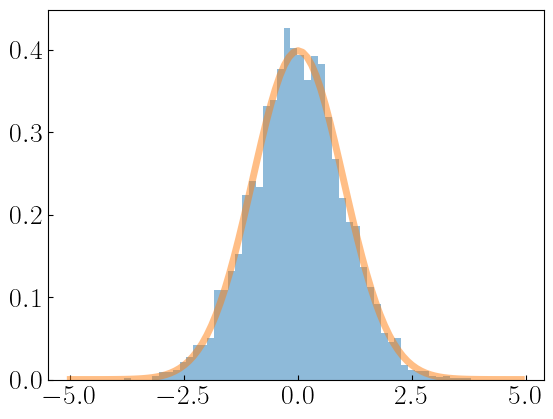

In [202]:
x = np.arange(-5,5, 0.1)

plt.hist(b1, density=True, bins=50, alpha=0.5);
# plt.hist(b2, density=True, bins=50, alpha=0.5);
plt.plot(x, normal(x), lw=5, alpha=0.5)
# plt.yscale('log')

Text(0, 0.5, '$\\delta t(f_2) \\textrm{ [Standardized]}$')

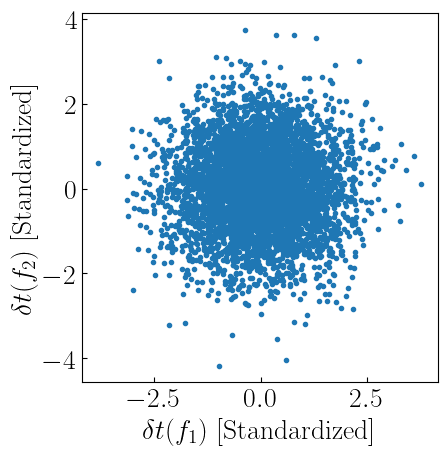

In [203]:
plt.plot(b1, b2, '.')
plt.gca().set_aspect('equal')
plt.xlabel(r'$\delta t(f_1) \textrm{ [Standardized]}$')
plt.ylabel(r'$\delta t(f_2) \textrm{ [Standardized]}$')

Text(0, 0.5, '$|\\widetilde{\\delta t}|^2$')

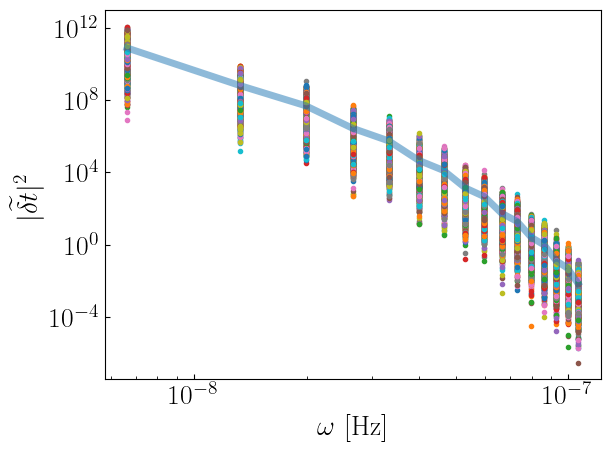

In [ ]:
for i in range(len(tmp)):
    plt.plot(test.wd, tmp[i], '.')
plt.plot(test.wd, aa, lw=5, alpha=0.5)
plt.plot(test.wd, 3e-23 * s(test.wd/2, test.tau),lw=10,alpha=0.3)
# plt.plot(test.wd, 1e+10 * k0(np.abs(test.wd * test.tau)) )
# plt.plot(test.wd, 1e-19/test.wd**4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\omega\,\,[\rm Hz]$')
plt.ylabel(r'$|\widetilde{\delta t}|^2$')

In [717]:
tmp = []
for i in range(500):
    tmp.append(test.delta_t_time())

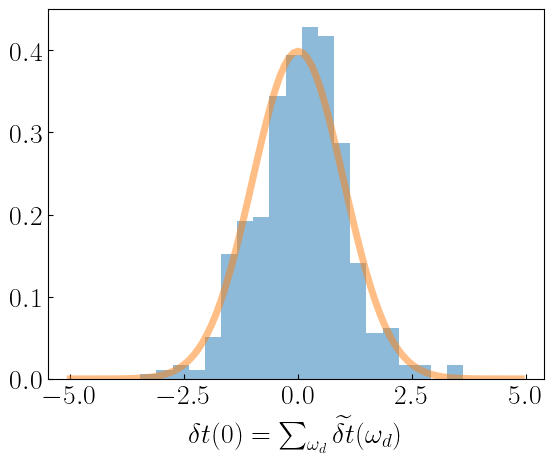

In [718]:
x = np.arange(-5,5, 0.1)
var = np.std(tmp)

plt.hist(tmp/var, bins=20, density=True, alpha=0.5)
plt.plot(x, 1 / np.sqrt(2 * np.pi) * np.exp(-x**2/2), lw=5, alpha=0.5)
plt.xlabel(r'$\delta t(0) = \sum_{\omega_d} \widetilde{\delta t}(\omega_d)$');
# plt.yscale('log')

# Numerical Simulation

In [ ]:
my_pos = []
my_rho = []

for _ in trange(1000):
    sim_FP = ULDM_FreeParticle(L=6, N=12, kJ=1e-3)
    sim_FP.solve(progress=False)
    # my_pos.append(sim_FP.pos_arr[-1][0])
    my_rho.append(sim_FP.rho)
    my_pos.append(sim_FP.pos_arr[:,0])

  0%|          | 0/1000 [00:00<?, ?it/s]

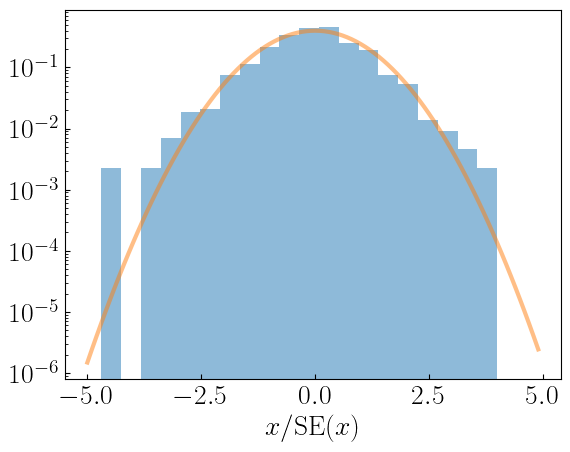

In [ ]:
x = np.arange(-5,5,0.1)
plt.hist(my_pos/np.std(my_pos), bins=20, density=True, alpha=0.5)
plt.plot(x, 1/np.sqrt(2 * np.pi) * np.exp(-x**2/2), lw=3, alpha=0.5)
plt.xlabel(r'$x / {\rm SE}(x)$')

plt.yscale('log')

In [ ]:
my_pos_ff = [[] for _ in range(len(my_pos))]
for i, pos in enumerate(my_pos):
    my_pos_ff[i] = fftn(pos)

In [ ]:
my_pos_ff = np.array(my_pos_ff)

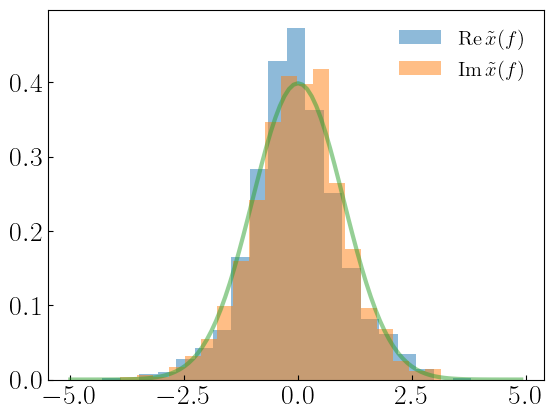

In [ ]:
x = np.arange(-5,5,0.1)
plt.hist(np.real(my_pos_ff[:,1]) / np.std(np.real(my_pos_ff[:,1])), bins=20, density=True, alpha=0.5,
         label=r'$\textrm{Re}\, \tilde x(f)$');
plt.hist(np.imag(my_pos_ff[:,1]) / np.std(np.imag(my_pos_ff[:,1])), bins=20, density=True, alpha=0.5,
         label=r'$\textrm{Im}\, \tilde x(f)$');
plt.plot(x, 1/np.sqrt(2 * np.pi) * np.exp(-x**2/2), lw=3, alpha=0.5)
plt.legend()
# plt.xlabel(r'$\tilde x / {\rm SE}(x)$')

# plt.yscale('log')

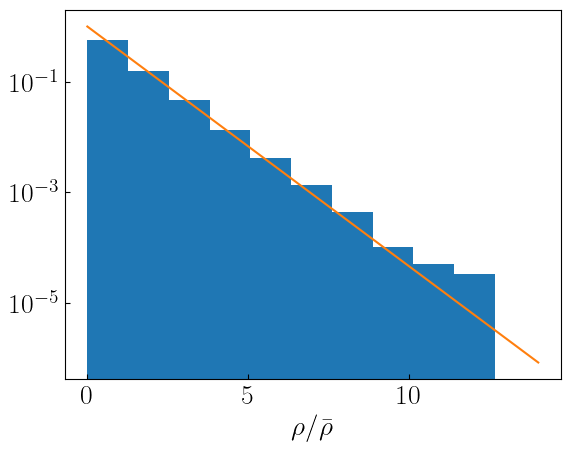

In [ ]:
plt.hist(np.concatenate(my_rho), density=True)
plt.plot(np.arange(0,15), np.exp(-np.arange(0,15)))
plt.xlabel(r'$\rho/\bar\rho$')
plt.yscale('log')

In [ ]:
my_rho_ff = [[] for _ in range(len(my_rho))]
for i, rho in enumerate(my_rho):
    my_rho_ff[i] = fftn(rho)

my_rho_ff = np.array(my_rho_ff)

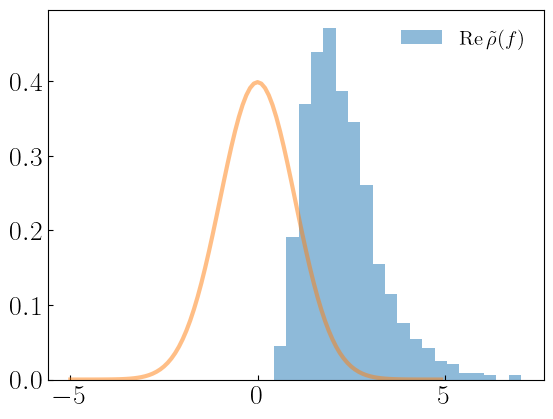

In [ ]:
idx=0
x = np.arange(-5,5,0.1)
plt.hist(np.real(my_rho_ff[:,idx]) / np.std(np.real(my_rho_ff[:,idx])), bins=20, density=True, alpha=0.5,
         label=r'$\textrm{Re}\, \tilde \rho(f)$');
# plt.hist(np.imag(my_rho_ff[:,idx]) / np.std(np.imag(my_rho_ff[:,idx])), bins=20, density=True, alpha=0.5,
#          label=r'$\textrm{Im}\, \tilde \rho(f)$');
plt.plot(x, 1/np.sqrt(2 * np.pi) * np.exp(-x**2/2), lw=3, alpha=0.5)
plt.legend()
# plt.xlabel(r'$\tilde x / {\rm SE}(x)$')

# plt.yscale('log')